In [1]:
import os
import pandas as pd
import numpy as np
from scipy import sparse
from implicit.bpr import BayesianPersonalizedRanking

Класс DataLoader предоставляет доступ к нужным данным

In [2]:
class DataLoader:
    def __init__(self, root: str) -> None:
        self._root = root
        
    def load_table(self, table_name: str) -> pd.DataFrame:
        return pd.read_csv(f"{self._root}/{table_name}.csv")

In [3]:
data_loader = DataLoader(root="./data")

train_purchases = data_loader.load_table("train")
test_purchases = data_loader.load_table("test")

display(train_purchases.head(), test_purchases.head())

,customer_id,product_id
0,1705131,120554
1,1624457,120555
2,1481210,120556
3,1788337,120557
4,443708,120558


,customer_id,product_id
0,1788295,120570
1,1567045,120578
2,1782630,120586
3,1788165,120658
4,1666277,120659


## Train
В качестве бейзлайн модели обучим Bayesian Personalized Ranking

In [4]:
model = BayesianPersonalizedRanking(factors=5, iterations=100)

Преобразуем таблицу действий в разреженную матрицу *item-user* и обучим на ней модель

In [5]:
train_csr = sparse.coo_matrix(
    (
        np.ones(train_purchases.customer_id.size, dtype=np.float32),
        (train_purchases.product_id, train_purchases.customer_id),
    )
).tocsr()


model.fit(train_csr)

## Evaluate

В качестве основной метрики будем использовать *MeanAveragePrecision@5*

In [6]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

Вспомогательные функции для получения рекомендаций

In [7]:
def recommend(model, user_ids, item_users):
    user_items = item_users.T.tocsr()
    recommendations = []
    for user_id in user_ids:
        recommendations.append(
            [x[0] for x in model.recommend(userid=user_id, user_items=user_items, N=10)]
        )
    return recommendations


def get_customer_purchases(purchases):
    relevant = (
        purchases.groupby("customer_id")["product_id"]
        .apply(lambda s: s.values.tolist())
        .reset_index()
    )
    relevant.rename(columns={"product_id": "product_ids"}, inplace=True)
    return relevant["customer_id"].tolist(), relevant["product_ids"].tolist()

Оценка модели

In [8]:
ids, purchases = get_customer_purchases(test_purchases)
recommendations = recommend(model, ids, train_csr)
score = mapk(purchases, recommendations, k=5)
score

0.34945372866127583

## Assignment

Некоторые пользователи совершали покупки и на другой платформе и у нас есть история их покупок

In [9]:
external_purchases = data_loader.load_table("external")

display(external_purchases.head())

,customer_id,product_id
0,5496085,362171
1,5544270,362172
2,5190646,362173
3,1289883,362174
4,803540,362175


In [10]:
external_purchases

,customer_id,product_id
0,5496085,362171
1,5544270,362172
2,5190646,362173
3,1289883,362174
4,803540,362175
...,...,...
1329172,5550868,447363
1329173,5212826,447364
1329174,1051589,447365
1329175,2106973,447366


Известно также, как сматчить customer_id двух платформ

In [11]:
customer_id_mapping = data_loader.load_table("ids_matching")
display(customer_id_mapping.head())

,source_customer_id,external_customer_id
0,17878,18
1,512572,19
2,141324,24
3,727278,26
4,581438,28


## Solution

 Интуитивное предположение - можно извлечь некую информацию о самих покупателях со второй платформы. Воспользовавшись этой информацией можно добавить несколько признаков в модель первой платформы.

В целом, можно использовать разные подходы - посчитать матрицу "взаимодействия" user-user, перемножить с матрицей интеракций user-item, получим более плотную матрицу user x item,  в которой будет и коллаборативная информация и информация о кластерах (если они будут на сторонныей платформе).
С другой стороны, доп. информацию можно сразу вбить в модель, напрямую id или векторизовать с tfidf.

In [12]:
#  Задачу для основной платформы можно решать как Item-centered, 
# то есть для каждого товара классификатор будет получать на вход вектор с признаками покупатяля,
# а на выходе сообщать нам, готов ли покупатель купить данный товар или еще нет.

In [13]:
print('число уникальных клиентов пл.2 =',external_purchases['customer_id'].nunique())
print('число уникальных товаров пл.2 =',external_purchases['product_id'].nunique())
print('число уникальных клиентов пл.1 =',train_purchases['customer_id'].nunique())
print('число уникальных товаров пл.1 =',train_purchases['product_id'].nunique())

число уникальных клиентов пл.2 = 444363
число уникальных товаров пл.2 = 257038
число уникальных клиентов пл.1 = 180805
число уникальных товаров пл.1 = 104534


In [14]:
train_purchases.shape

(472794, 2)

In [15]:
test_purchases.shape

(24288, 2)

посмотрим на распределения

<AxesSubplot:>

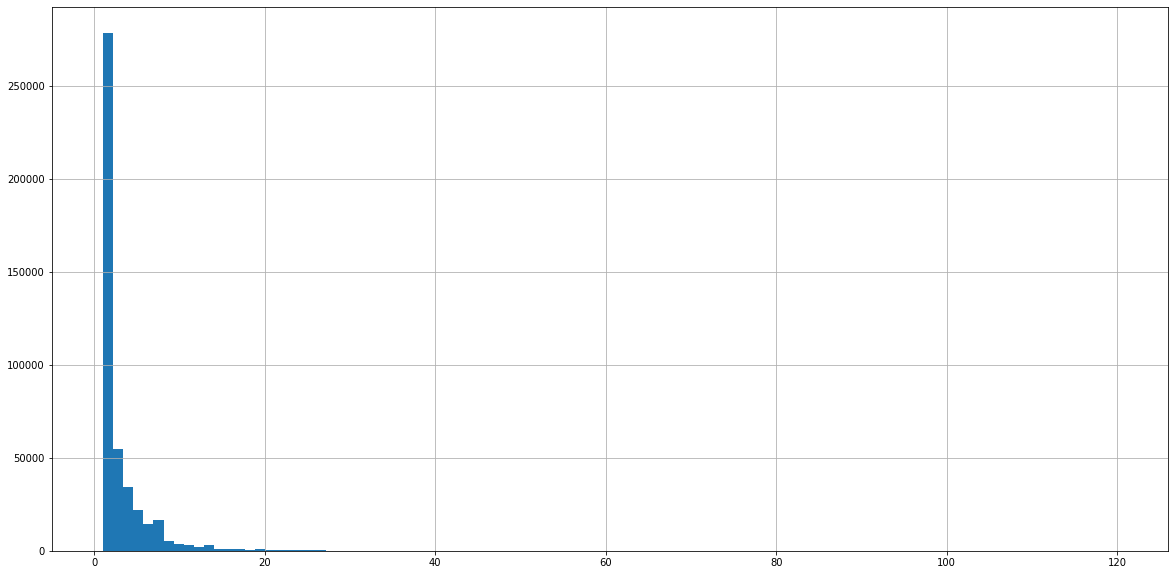

In [16]:
external_purchases['customer_id'].value_counts().hist(bins=100,figsize=(20,10))

<AxesSubplot:>

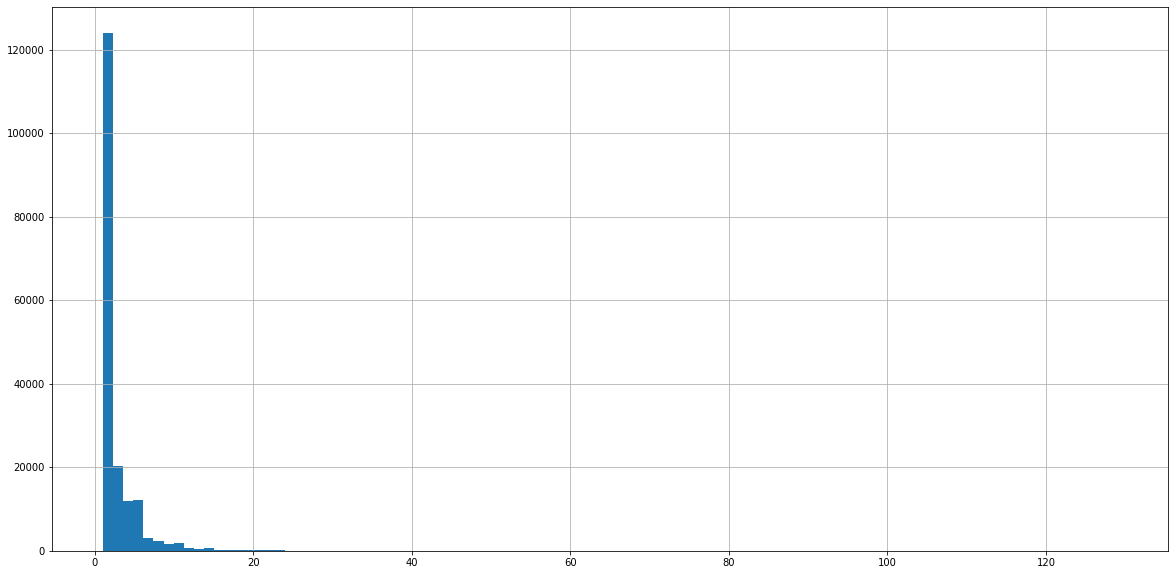

In [17]:
train_purchases['customer_id'].value_counts().hist(bins=100,figsize=(20,10))

уберем выбросы данных в виде покупателей с большим числом покупок (>20)

In [18]:
counts = external_purchases['customer_id'].value_counts()
ext_filtered = external_purchases[external_purchases['customer_id'].isin(counts[counts < 20].index)]

In [19]:
print(external_purchases.shape[0]-ext_filtered.shape[0])

89870


In [20]:
counts = train_purchases['customer_id'].value_counts()
train_filtered = train_purchases[train_purchases['customer_id'].isin(counts[counts < 20].index)]
print(train_purchases.shape[0]-train_filtered.shape[0])

23711


Хотя это не должо сильно повлиять на резутать т.к значимых выбросов нет .

In [21]:
import turicreate as tc
sf = tc.SFrame(train_filtered)

In [22]:
m=tc.recommender.item_similarity_recommender.create(sf, user_id='customer_id', 
                                                  item_id='product_id', target=None, 
                                                  user_data=None, 
                                                  item_data=None, verbose=True, 
                                                  target_memory_usage=3*1024*1024*1024)

Preparing data set.

Data has 449083 observations with 179952 users and 101672 items.

Data prepared in: 0.40196s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.002ms                        | 0.5        |

| 102.777ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 2.196ms                            | 0          |

| 93.523ms                           | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 326.107ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.88s                               | 100              | 101672          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.95254s

In [23]:
recs = m.recommend(k=5)

recommendations finished on 1000/179952 queries. users per second: 1234.33

recommendations finished on 2000/179952 queries. users per second: 1180.32

recommendations finished on 3000/179952 queries. users per second: 1179.22

recommendations finished on 4000/179952 queries. users per second: 1200.03

recommendations finished on 5000/179952 queries. users per second: 1206.58

recommendations finished on 6000/179952 queries. users per second: 1223.7

recommendations finished on 7000/179952 queries. users per second: 1231.78

recommendations finished on 8000/179952 queries. users per second: 1228.93

recommendations finished on 9000/179952 queries. users per second: 1233.38

recommendations finished on 10000/179952 queries. users per second: 1221.1

recommendations finished on 11000/179952 queries. users per second: 1227.27

recommendations finished on 12000/179952 queries. users per second: 1229.53

recommendations finished on 13000/179952 queries. users per second: 1230.77

recommendations finished on 14000/179952 queries. users per second: 1231.11

recommendations finished on 15000/179952 queries. users per second: 1224.67

recommendations finished on 16000/179952 queries. users per second: 1228.73

recommendations finished on 17000/179952 queries. users per second: 1225.55

recommendations finished on 18000/179952 queries. users per second: 1224.18

recommendations finished on 19000/179952 queries. users per second: 1228.28

recommendations finished on 20000/179952 queries. users per second: 1231.74

recommendations finished on 21000/179952 queries. users per second: 1234.48

recommendations finished on 22000/179952 queries. users per second: 1225.34

recommendations finished on 23000/179952 queries. users per second: 1228.93

recommendations finished on 24000/179952 queries. users per second: 1231.33

recommendations finished on 25000/179952 queries. users per second: 1231.88

recommendations finished on 26000/179952 queries. users per second: 1233.5

recommendations finished on 27000/179952 queries. users per second: 1232.95

recommendations finished on 28000/179952 queries. users per second: 1227.2

recommendations finished on 29000/179952 queries. users per second: 1220.83

recommendations finished on 30000/179952 queries. users per second: 1214.81

recommendations finished on 31000/179952 queries. users per second: 1213.66

recommendations finished on 32000/179952 queries. users per second: 1207.06

recommendations finished on 33000/179952 queries. users per second: 1208.17

recommendations finished on 34000/179952 queries. users per second: 1210.49

recommendations finished on 35000/179952 queries. users per second: 1212.9

recommendations finished on 36000/179952 queries. users per second: 1215.28

recommendations finished on 37000/179952 queries. users per second: 1216.92

recommendations finished on 38000/179952 queries. users per second: 1219.38

recommendations finished on 39000/179952 queries. users per second: 1222.32

recommendations finished on 40000/179952 queries. users per second: 1224.36

recommendations finished on 41000/179952 queries. users per second: 1220.74

recommendations finished on 42000/179952 queries. users per second: 1219.8

recommendations finished on 43000/179952 queries. users per second: 1222

recommendations finished on 44000/179952 queries. users per second: 1223.92

recommendations finished on 45000/179952 queries. users per second: 1220.23

recommendations finished on 46000/179952 queries. users per second: 1220.35

recommendations finished on 47000/179952 queries. users per second: 1222.14

recommendations finished on 48000/179952 queries. users per second: 1216.08

recommendations finished on 49000/179952 queries. users per second: 1217.63

recommendations finished on 50000/179952 queries. users per second: 1217.43

recommendations finished on 51000/179952 queries. users per second: 1217.02

recommendations finished on 52000/179952 queries. users per second: 1217.28

recommendations finished on 53000/179952 queries. users per second: 1217.5

recommendations finished on 54000/179952 queries. users per second: 1216.79

recommendations finished on 55000/179952 queries. users per second: 1218.74

recommendations finished on 56000/179952 queries. users per second: 1219.66

recommendations finished on 57000/179952 queries. users per second: 1221.5

recommendations finished on 58000/179952 queries. users per second: 1223.63

recommendations finished on 59000/179952 queries. users per second: 1225.68

recommendations finished on 60000/179952 queries. users per second: 1227.41

recommendations finished on 61000/179952 queries. users per second: 1228.4

recommendations finished on 62000/179952 queries. users per second: 1229.03

recommendations finished on 63000/179952 queries. users per second: 1225.59

recommendations finished on 64000/179952 queries. users per second: 1226.6

recommendations finished on 65000/179952 queries. users per second: 1228.18

recommendations finished on 66000/179952 queries. users per second: 1229.68

recommendations finished on 67000/179952 queries. users per second: 1226.03

recommendations finished on 68000/179952 queries. users per second: 1222.94

recommendations finished on 69000/179952 queries. users per second: 1223.86

recommendations finished on 70000/179952 queries. users per second: 1224.96

recommendations finished on 71000/179952 queries. users per second: 1220.48

recommendations finished on 72000/179952 queries. users per second: 1217.81

recommendations finished on 73000/179952 queries. users per second: 1215.39

recommendations finished on 74000/179952 queries. users per second: 1212.8

recommendations finished on 75000/179952 queries. users per second: 1208.67

recommendations finished on 76000/179952 queries. users per second: 1201.76

recommendations finished on 77000/179952 queries. users per second: 1198.15

recommendations finished on 78000/179952 queries. users per second: 1197.8

recommendations finished on 79000/179952 queries. users per second: 1196.71

recommendations finished on 80000/179952 queries. users per second: 1191.94

recommendations finished on 81000/179952 queries. users per second: 1185.89

recommendations finished on 82000/179952 queries. users per second: 1184.76

recommendations finished on 83000/179952 queries. users per second: 1184.37

recommendations finished on 84000/179952 queries. users per second: 1181.68

recommendations finished on 85000/179952 queries. users per second: 1176.78

recommendations finished on 86000/179952 queries. users per second: 1174.33

recommendations finished on 87000/179952 queries. users per second: 1171.35

recommendations finished on 88000/179952 queries. users per second: 1167.24

recommendations finished on 89000/179952 queries. users per second: 1163.79

recommendations finished on 90000/179952 queries. users per second: 1161.84

recommendations finished on 91000/179952 queries. users per second: 1159.09

recommendations finished on 92000/179952 queries. users per second: 1155.86

recommendations finished on 93000/179952 queries. users per second: 1153.88

recommendations finished on 94000/179952 queries. users per second: 1150.25

recommendations finished on 95000/179952 queries. users per second: 1149.73

recommendations finished on 96000/179952 queries. users per second: 1149.79

recommendations finished on 97000/179952 queries. users per second: 1150.18

recommendations finished on 98000/179952 queries. users per second: 1150.72

recommendations finished on 99000/179952 queries. users per second: 1151.28

recommendations finished on 100000/179952 queries. users per second: 1151.58

recommendations finished on 101000/179952 queries. users per second: 1150.4

recommendations finished on 102000/179952 queries. users per second: 1150.67

recommendations finished on 103000/179952 queries. users per second: 1150.61

recommendations finished on 104000/179952 queries. users per second: 1150.4

recommendations finished on 105000/179952 queries. users per second: 1149.48

recommendations finished on 106000/179952 queries. users per second: 1148.22

recommendations finished on 107000/179952 queries. users per second: 1147.27

recommendations finished on 108000/179952 queries. users per second: 1146.39

recommendations finished on 109000/179952 queries. users per second: 1146

recommendations finished on 110000/179952 queries. users per second: 1147.24

recommendations finished on 111000/179952 queries. users per second: 1148.61

recommendations finished on 112000/179952 queries. users per second: 1149.2

recommendations finished on 113000/179952 queries. users per second: 1148.74

recommendations finished on 114000/179952 queries. users per second: 1146.67

recommendations finished on 115000/179952 queries. users per second: 1144.23

recommendations finished on 116000/179952 queries. users per second: 1145.04

recommendations finished on 117000/179952 queries. users per second: 1144.57

recommendations finished on 118000/179952 queries. users per second: 1145.72

recommendations finished on 119000/179952 queries. users per second: 1146.14

recommendations finished on 120000/179952 queries. users per second: 1145.86

recommendations finished on 121000/179952 queries. users per second: 1143.31

recommendations finished on 122000/179952 queries. users per second: 1141.3

recommendations finished on 123000/179952 queries. users per second: 1139.03

recommendations finished on 124000/179952 queries. users per second: 1139.9

recommendations finished on 125000/179952 queries. users per second: 1141.33

recommendations finished on 126000/179952 queries. users per second: 1142.88

recommendations finished on 127000/179952 queries. users per second: 1144.28

recommendations finished on 128000/179952 queries. users per second: 1144.65

recommendations finished on 129000/179952 queries. users per second: 1144.2

recommendations finished on 130000/179952 queries. users per second: 1145.54

recommendations finished on 131000/179952 queries. users per second: 1146.33

recommendations finished on 132000/179952 queries. users per second: 1146.85

recommendations finished on 133000/179952 queries. users per second: 1147.69

recommendations finished on 134000/179952 queries. users per second: 1148.49

recommendations finished on 135000/179952 queries. users per second: 1149.03

recommendations finished on 136000/179952 queries. users per second: 1149.55

recommendations finished on 137000/179952 queries. users per second: 1150.65

recommendations finished on 138000/179952 queries. users per second: 1149.57

recommendations finished on 139000/179952 queries. users per second: 1148.87

recommendations finished on 140000/179952 queries. users per second: 1149.24

recommendations finished on 141000/179952 queries. users per second: 1148.44

recommendations finished on 142000/179952 queries. users per second: 1147.47

recommendations finished on 143000/179952 queries. users per second: 1146.94

recommendations finished on 144000/179952 queries. users per second: 1146.96

recommendations finished on 145000/179952 queries. users per second: 1147.44

recommendations finished on 146000/179952 queries. users per second: 1147.78

recommendations finished on 147000/179952 queries. users per second: 1148.19

recommendations finished on 148000/179952 queries. users per second: 1146.73

recommendations finished on 149000/179952 queries. users per second: 1145.55

recommendations finished on 150000/179952 queries. users per second: 1145.64

recommendations finished on 151000/179952 queries. users per second: 1144.99

recommendations finished on 152000/179952 queries. users per second: 1145.89

recommendations finished on 153000/179952 queries. users per second: 1146.71

recommendations finished on 154000/179952 queries. users per second: 1147.59

recommendations finished on 155000/179952 queries. users per second: 1148.41

recommendations finished on 156000/179952 queries. users per second: 1148.96

recommendations finished on 157000/179952 queries. users per second: 1148.97

recommendations finished on 158000/179952 queries. users per second: 1149.06

recommendations finished on 159000/179952 queries. users per second: 1149.48

recommendations finished on 160000/179952 queries. users per second: 1149.23

recommendations finished on 161000/179952 queries. users per second: 1148.97

recommendations finished on 162000/179952 queries. users per second: 1149.1

recommendations finished on 163000/179952 queries. users per second: 1149.58

recommendations finished on 164000/179952 queries. users per second: 1149.94

recommendations finished on 165000/179952 queries. users per second: 1150.36

recommendations finished on 166000/179952 queries. users per second: 1150.96

recommendations finished on 167000/179952 queries. users per second: 1150.95

recommendations finished on 168000/179952 queries. users per second: 1150.73

recommendations finished on 169000/179952 queries. users per second: 1150.93

recommendations finished on 170000/179952 queries. users per second: 1150.98

recommendations finished on 171000/179952 queries. users per second: 1151.28

recommendations finished on 172000/179952 queries. users per second: 1149.74

recommendations finished on 173000/179952 queries. users per second: 1149.73

recommendations finished on 174000/179952 queries. users per second: 1149.31

recommendations finished on 175000/179952 queries. users per second: 1149.43

recommendations finished on 176000/179952 queries. users per second: 1149.22

recommendations finished on 177000/179952 queries. users per second: 1142.21

recommendations finished on 178000/179952 queries. users per second: 1133.63

recommendations finished on 179000/179952 queries. users per second: 1126.11

In [24]:
df=recs.to_dataframe()

In [25]:
predictions = df['product_id'].tolist()
k = 5
chunk = [predictions[i:i + k] for i in range(0, len(predictions), k)]
ids, purchases = get_customer_purchases(test_purchases)
score = mapk(purchases, chunk, k=5)
score

0.15939173405211138

видно, что скор упал. Нужно пробовать идти другими путемя, 
 можно посчитать матрицу взаимодействий user-user на второй платформе, перемножить с 
item-user основной и применить тот же BPR (implicit/ lightFM).
Можно взять модель типа word2vec и в нее закинуть взаимодействия с обоих сервисов (предложение == последовательность айтимов одного юзера), получить таким образом вектора юзеров с учетом истории в двух сервисах. Дальше вектор пользователя счиать как сумму векторов айтимов, с которыми он взаимодействовал (предварительно их нормализовать или домножить на BM25/IDF). Можно взять вектора юзеров с одного сервиса и инициализировать вектора соотвествующих юзеров во втором сервисе перед тем как начать факторизацию матрицы, эта информация учтется при факторизации (тут важно чтобы в первом шаге ALS фиксировались вектора айтимов и вычислялись вектора пользователей). Затраченное время ~3ч (на текущей работе сдача проекта, поэтому не смог уделить тесту больше времени).

In [26]:
customer_id_mapping = customer_id_mapping.rename(columns={"source_customer_id": "customer_id"})
external_purchases = external_purchases.rename(columns={"customer_id": "external_customer_id"})
res = pd.merge(train_purchases, customer_id_mapping, on="customer_id", how="inner", indicator=True)
res = res.drop(columns=['_merge'], axis=1)
res = pd.merge(res, external_purchases, on="external_customer_id", how="inner", indicator=True)
res = res.drop(columns=['_merge'], axis=1)
res

,customer_id,product_id_x,external_customer_id,product_id_y
0,1705131,120554,1512500,212729
1,1705131,120554,1512500,212729
2,1705131,120554,1512500,2
3,1705131,120554,1512500,2
4,1705131,120554,1512500,2
...,...,...,...,...
2435634,1821265,134934,5624802,451422
2435635,1821265,134934,5624802,448850
2435636,1810189,134935,3080864,354806
2435637,1810189,134935,3080864,433374
